<h1>Audio Chord Estimation using Neural Networks</h1>
<h4>Theofanis Aslanidis</h4>
    

<h3>Abstract</h3>
In this project, we are going to explore the use of deep neural networks for recognizing audio chords, using the Isophonics dataset - the one that is used on MIREX.<br>
For the first steps of the implementation, I'm using a test-dataset only with one album, because the memory needed is very large, due to the one hot representation. So I'm using only the album "<i>Let it Be</i>" until I implement a batch training, where I won't need to load all data on memory at once.<br><br>
<i>In order to run the notebook you will need my dataset, and ~32GB ram</i>

In [1]:
import sys
# do this only once
sys.path.append('./src/audio-processing/')
sys.path.append('./src/data-processing/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#sklearn for normalization
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow import keras

#padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

#librosa
import librosa

#import custom modules
import filters
import spectrograms
import audiofiles
import annotation_processing

<h3>Audio File pre-processing</h3>

Script to Convert <b>mp3 files to wav</b>

In [4]:
audiofiles.mp3_to_wav()

Script to Convert files from <b>stereo to mono</b>

In [81]:
audiofiles.stereo_to_mono()

<h3>Loading Datasets</h3>
<h4>Annotations</h4>

From the <b>isophonics</b> dataset, in the chordlab folder, there are all the annotations we need.<br>
Read all those chordlab files as <b>pandas dataframes</b> and store them in a dictionary of dataframes.

In [3]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

For all the tracks we have the annotations, we need to load the appropriate audio track for each one, create the spectrogram, and store the (time, frequency, power) vector.<br>
<b>Steps:</b>
<ul>
    <li> Browse to those wav files
    <li> Read with wavfile from SciPy
    <li> Create spectrogram with signal spectrogram
</ul>

### Spectrograms

- Creating Spectrograms with different timesteps
- Creating Spectrograms with more timesteps
- Creating Spectrograms with neighborhoods on chords changes

In [4]:
### get all audio files and create spectrogram for each track
audiofiles_path='Audiofiles/The Beatles'
n_fft=2048
nperseg=2048
Spectrograms, frequencies_num = spectrograms.create_spectrograms(n_fft, nperseg, audiofiles_path)

In [5]:
print ('Number of unique frequncies: ', frequencies_num)

Number of unique frequncies:  1025


Resulting spectrograms contain info for 1025 frequency range

## Data preprocessing
**Convert data into input that I can feed in the neural network**
<br>
### 2 Ways of handling annotations:
- **One Hot Encodings**<br><br>
Just like NLP, every chord will have a one hot vector representation.<br>
<br>
- **Chord/Mode/Sus**<br><br>
Try an encoding(hashing) for each chord, and when we stumble upon each chord we hash it to a unique combination.<br>
<br>**Example**:<br>
<ol>
    <li> Find the chord between the 12 chords</li>
    <b>Chords:</b> C, C#, Db, D, D#, E, F, etc.<br>
    <li>Find the mode of the chord (major/minor)</li>
    <b>Mode:</b><br>
    Minor Chord: 0<br>
    Major Chord: 1<br>
    <li>Find any notes outside of the basic tonic triad</li>
    <b>Sustained: </b>
    4,6,7,9,11,13<br>
    </ol>

In [6]:
### Load all chords in a dictionary
Chords = []
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: Chords.append(row['Chord'])
                
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  407


For one album we have 68 Chords, so our vectors are going to be <b>one hot vectors</b> of 68 size. (67 zeros and 1 one)<br>
Create one hot encodings of the chords, with <b>pandas Series + get_dummies</b><br>
#### One Hot Encodings
<br>
With <b>pandas</b>:

In [6]:
num_chords = len(Chords)
s = pd.Series(Chords)
OneHotEncodings = pd.get_dummies(s)

With <b>Sklearn</b>:<br>
<i>(which provides us with inverse transformation, for the results.)</i>

In [7]:
encoder = OneHotEncoder()
encoder.fit(np.array(pd.Series(Chords)).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

<h3>Indexing chords with timestamps</h3>

<img src="images/Vector_flow.png" width="800" />

<caption><center> <b>Figure 1</b>: Annotation Data Processing.</center></caption>

Now we have to align the <b>timing of the chords</b> with the <b>times array</b><br>
To achieve that lets try to convert the timing - chords data of the .lab files in the same representation as the spectrograms data.<br>
We will keep the same timeline (times), and using the timing<br>
<b><font color='red'>Warning</font>: This is computational expensive for the cpu. If you have it ready, you can load it below with pickle.</b><br> 

In [ ]:
Artist='The Beatles'
Timeseries=Spectrograms
chords2vec = {}
for album in Chordlab[Artist].keys():
    chords2vec[album] = {}
    for track_no in Chordlab[Artist][album].keys():
        times = Timeseries[Artist][album][track_no]['times']
        df_rows = Chordlab[Artist][album][track_no].itertuples()
        index = 0
        max_len = len(Chordlab[Artist][album][track_no])
        vector = np.empty((len(Chords),))
        row = next(df_rows)
        for timestamp in times:
            if ((index + 1) < max_len) & (timestamp >= row[2]):
                index += 1
                row = next(df_rows)
            vector = np.column_stack((vector, encoder.transform([[row[3]]]).toarray()[0]))
        chords2vec[album][track_no] = vector
        print(album, ': track ', track_no, ' completed')

# Take care fo the one extra row in the beginning of the array
for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        chords2vec[album][track_no] = np.delete(chords2vec[album][track_no], 0, 1)

Now we have our 4D data ready in a dictionary to go into our model for training.<br>
3 dimensions (times, frequencies, power) will go as X_train and chords2vec will go as Y_train<br><br>

<b>Store - Load Data with pickle</b>

In [14]:
### STORE
import pickle

with open('full_indexed.pickle', 'wb') as handle:
    pickle.dump(chords2vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
### LOAD
import pickle

with open('full_indexed.pickle', 'rb') as handle:
    chords2vec = pickle.load(handle)

## Train/Test Data Initialization
<br>
After appending all the data together, we slice them into batches, as shown below:<br>
(Example is for the X_train, we do exactly the same for the Y_train - chord annotations.)
<br>

### Approach 1
- Batch per song with padding sequences

In [9]:
x_train = []
y_train = []
test_track_no = '06'
for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        # test data
        if track_no == test_track_no and album == '12_-_Let_It_Be':
            x_test = Spectrograms['The Beatles'][album][track_no]['powerSpectrum'].T
            y_test = chords2vec[album][track_no].T
            continue
        # train data
        x_train.append(Spectrograms['The Beatles'][album][track_no]['powerSpectrum'].T)
        y_train.append(chords2vec[album][track_no].T)
        
maxlen = len(max(x_train, key=len))

x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
y_train = pad_sequences(y_train, maxlen=maxlen, padding='post')
x_test = pad_sequences([x_test], maxlen=maxlen, padding='post')
y_test = pad_sequences([y_test], maxlen=maxlen, padding='post')

<h4>Normalization</h4>

In [10]:
scalers = {}
for i in range(x_train.shape[0]):
    scalers[i] = StandardScaler()
    x_train[i, :, :] = scalers[i].fit_transform(x_train[i, :, :]) 

test_scaler = StandardScaler()
x_test[0, :, :] = test_scaler.fit_transform(x_test[0, :, :])

# due to some error in matmul
x_test = tf.cast(x_test, tf.float32)

In [11]:
chunk_size = maxlen

### Approach 2
- Stack all data and then slice them into chunks

<img src="images/slicing.png" width="800" />

<caption><center> <b>Figure 2</b>: Slicing data into Batches.</center></caption>

In this article the following is stated.<br>
https://tm3.ghost.io/2018/09/05/building-lstms-for-time-series-forecasting/<br>
<i>"Instead of one sequence of 1870, you could have many sequences of let's say 20. Your sequences should be overlapping windows `[0-20], [1-21], [2-22]`, etc, so your final shape would be something like `(1850, 20, 14)`.Same process for your test data. Break into subsequences of the same length as training. You will have to play around with finding what a good subsequence length is. It is extremely important to have many different ways of slicing your data. If you train on just one super long sequence it will probably not learn anything interesting."</i>

### Constructing Numpy arrays for Train-Test data

In [9]:
# Find the chunk size
chunk_size = 500

In [14]:
x_train = np.zeros((1,chunk_size,frequencies_num)) #num of frequencies
y_train = np.zeros((1,chunk_size,len(Chords)))
x_test = np.zeros((1,chunk_size,frequencies_num)) #num of frequencies
y_test = np.zeros((1,chunk_size,len(Chords)))

#test track
test_track_no = '01'
album_test_track = '09_-_Magical_Mystery_Tour'

for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        timestep = 0
        # size of the current track
        chunks = chords2vec[album][track_no].T.shape[0]
        # track frequencies
        spectrogram = Spectrograms['The Beatles'][album][track_no]['powerSpectrum'].T
        # track annotations
        annotations = chords2vec[album][track_no].T
        # slice and stack train-test data
        if track_no != test_track_no or album != album_test_track:
            # train tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(spectrogram[timestep:timestep+chunk_size,:], (1, chunk_size, frequencies_num)) #num of frequencies
                    x_train = np.append(x_train, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, len(Chords)))
                    y_train = np.append(y_train, batch_y, axis = 0)
                else:
                    batch_x = spectrogram[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,frequencies_num))))
                        batch_y = np.vstack((batch_y, encoder.transform([['N']]).toarray()[0]))
                    x_train = np.append(x_train, np.array([batch_x]), axis = 0)
                    y_train = np.append(y_train, np.array([batch_y]), axis = 0)
                timestep += chunk_size
        else:
            # test tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(spectrogram[timestep:timestep+chunk_size,:], (1, chunk_size, frequencies_num)) #num of frequencies
                    x_test = np.append(x_test, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, len(Chords)))
                    y_test = np.append(y_test, batch_y, axis = 0)
                else:
                    batch_x = spectrogram[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,frequencies_num))))
                        batch_y = np.vstack((batch_y, encoder.transform([['N']]).toarray()[0]))
                    x_test = np.append(x_test, np.array([batch_x]), axis = 0)
                    y_test = np.append(y_test, np.array([batch_y]), axis = 0)
                # augment timesteps
                timestep += chunk_size

print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1520, 500, 1025) (1520, 500, 407) (10, 500, 1025) (10, 500, 407)


Delete the first row from every array because of the append, which left it all zeros.

In [15]:
#delete first line batch of array because its zeros
x_train = np.delete(x_train,0,0)
y_train = np.delete(y_train,0,0)
x_test = np.delete(x_test,0,0)
y_test = np.delete(y_test,0,0)

In [16]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1519, 500, 1025)
(1519, 500, 407)
(9, 500, 1025)
(9, 500, 407)


## Chord Embeddings

In [99]:
def chord_embeddings(Chordlab, Timeseries):
    Chord_Progressions = []
    progression = []
    for Artist in Chordlab.keys():
        for album in Chordlab[Artist].keys():
            for track_no in Chordlab[Artist][album].keys():
                if ((track_no == test_track_no) and (album == album_test_track)): continue
                times = Timeseries[Artist][album][track_no]['times']
                maxtimes = max(times)
                df_rows = Chordlab[Artist][album][track_no].itertuples()
                index = 0
                slice_count = 0
                max_len = len(Chordlab[Artist][album][track_no])
                vector = np.empty((len(Chords),))
                row = next(df_rows)
                for timestamp in times:
                    
                    if ((index + 1) < max_len) & (timestamp >= row[2]):
                        index += 1
                        row = next(df_rows)
                       
                    progression.append(row[3])
                    slice_count += 1
                    
                    if (slice_count % chunk_size) == 0 or timestamp == maxtimes:
                        Chord_Progressions.append(progression)
                        progression = []
    
    return Chord_Progressions

#### Build chord progressions

In [110]:
Chord_Progressions = chord_embeddings(Chordlab, Spectrograms)

**List of sequences**

Transform <'list of lists'> with the progressions into a <'ist of sentences'> separated by whitespace.

In [111]:
Chord_Sentences = []
for progression_set in Chord_Progressions:
    progression_sentence = ' '.join(progression_set)
    Chord_Sentences.append(progression_sentence)

**From sentences of 'C G D' -> sentences of one hot representation**

In [112]:
embedded_progressions = [one_hot(progression_sentence, len(Chords)) for progression_sentence in Chord_Sentences]

**Padding**

In [113]:
#padding
maxLen = chunk_size
embeddings_train = pad_sequences(embedded_progressions, maxlen=maxLen, padding='post')
embeddings_tests = np.zeros((9, maxLen))

In [119]:
print (embeddings_train.shape)

(1519, 500)


<b>If you have limited RAM clear this 4GB dictionary for memory issues !</b>

In [16]:
#spectrogram dict is no longer necessary
Spectrograms.clear()

# Neural Network

Let's play with various RNNs with tensorflow, we will play with combinations of:
- LSTM
- Bidirectional LSTM
- GRU
- Convolutional Neural Net
- Embeddings

In [17]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, BatchNormalization, GRU, concatenate, Conv1D, Conv2D, Flatten,MaxPooling1D, LocallyConnected1D, Activation, TimeDistributed, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform

***
- Reshape in order to apply Time Distributed Convolutions

In [124]:
# Reshaping
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

- Reshape to its original shape

In [134]:
#Reshape back
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], x_test.shape[2]))

## Single Input Models

**Simple 2 Layer Bidirectional LSTM**
1. Data -> 2 Layers BLSTM
2. output -> Dense -> predictions

In [154]:
def BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    
    #BLSTM
    x = Bidirectional(LSTM(units = 64, 
                           batch_input_shape = (batch_size, timesteps, frequencies_num),
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences = True))(main_input)
    x = Dropout(0.5)(x)
    
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 64,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences=True))(x)
    x = Dropout(0.5)(x)
    
    x = Dense(512)(x)
    x = Activation('sigmoid')(x)
    
    #Dense for classification
    x = Dense(chords_num)(x)
    main_output = Activation('softmax')(x)
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

**Stacked Convolutions + BLSTM**
1. Data -> Convolutions -> c
2. c pass through 2 Layers of BLSTM
3. x -> Dense -> predictions

*420 secs per epoch on i7 9700K* -> So I'm going to need a gpu in order to see good results.

In [152]:
def TS_Conv1D_BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num,1), name='main_input')
    
    
    #CNN 1
    c = TimeDistributed(Conv1D(filters=12, 
                   kernel_size=5, 
                   padding='same'))(main_input)
    
    #CNN 2
    c = TimeDistributed(Conv1D(filters=12, 
                   kernel_size=5, 
                   padding='same'))(c)
    
    c = TimeDistributed(MaxPooling1D(2,2))(c)
    c = Dropout(0.5)(c)
    
    #CNN 1
    c = TimeDistributed(Conv1D(filters=24, 
                   kernel_size=5, 
                   padding='same'))(c)
    
    #CNN 2
    c = TimeDistributed(Conv1D(filters=24, 
                   kernel_size=5, 
                   padding='same'))(c)
    
    c = TimeDistributed(MaxPooling1D(2,2))(c)
    c = Dropout(0.5)(c)
    
    #x = TimeDistributed(BatchNormalization())(c)
    
    x = TimeDistributed(Flatten())(c)
    
    x = Dense(128)(x)
    x = Activation('sigmoid')(x)
    
    #BLSTM
    x = Bidirectional(LSTM(units = 64, return_sequences = True))(x)
    x = Dropout(0.5)(x)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 64, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    #Dense for classification
    x = Dense(chords_num)(x)
    main_output = Activation('softmax')(x)
    
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

### Executions

#### Optimizers

In [130]:
SGD_Optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9)
Adam_Optimizer = keras.optimizers.Adam()
AdaGrad_Optimizer = keras.optimizers.Adagrad()

#### Summary

In [132]:
# MODEL SUMMARY
model = BLSTM_2Layer(len(Chords), frequencies_num, chunk_size, batch_size)

model.compile(optimizer=Adam_Optimizer,
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 500, 1025)]       0         
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 500, 128)          558080    
_________________________________________________________________
dropout_82 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 500, 128)          98816     
_________________________________________________________________
dropout_83 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
dense_43 (Dense)             (None, 500, 256)          33024     
_________________________________________________________________
activation_52 (Activation)   (None, 500, 256)          0  

#### Fit

In [156]:
# MODEL FIT
epochs = 27
batch_size = 32

model = BLSTM_2Layer(len(Chords), frequencies_num, chunk_size, batch_size)

SGD_Optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9)
Adam_Optimizer = keras.optimizers.Adam()
AdaGrad_Optimizer = keras.optimizers.Adagrad()

model.compile(optimizer=Adam_Optimizer,
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


# train
test_data = x_test
history_callback = model.fit(x_train, y_train, epochs=epochs,
          validation_data=(x_test, y_test), batch_size=batch_size, verbose=1)

Train on 1519 samples, validate on 9 samples
Epoch 1/27
1519/1519 [==============================] - 38s 25ms/sample - loss: 5.3966 - accuracy: 0.1932 - val_loss: 3.4483 - val_accuracy: 0.4509
Epoch 2/27
1519/1519 [==============================] - 33s 22ms/sample - loss: 3.6663 - accuracy: 0.3459 - val_loss: 2.4938 - val_accuracy: 0.5600
Epoch 3/27
1519/1519 [==============================] - 33s 21ms/sample - loss: 3.1264 - accuracy: 0.3887 - val_loss: 2.1584 - val_accuracy: 0.5742
Epoch 4/27
1519/1519 [==============================] - 33s 22ms/sample - loss: 2.8690 - accuracy: 0.4108 - val_loss: 1.9987 - val_accuracy: 0.5916
Epoch 5/27
1519/1519 [==============================] - 33s 21ms/sample - loss: 2.6982 - accuracy: 0.4265 - val_loss: 1.8633 - val_accuracy: 0.6191
Epoch 6/27
1519/1519 [==============================] - 32s 21ms/sample - loss: 2.6028 - accuracy: 0.4360 - val_loss: 1.9382 - val_accuracy: 0.6111
Epoch 7/27
1519/1519 [==============================] - 33s 22ms/sa

In [174]:
# evaluate on test set
loss, accuracy = model.evaluate([x_test], y_test, verbose=0)
print("Loss: \t\t% 3.3f \nAccuracy: \t% 3.2f %%" %(loss, 100*accuracy))

Loss: 		 1.683 
Accuracy: 	 63.20 %


<h3>Transform predictions into Chords</h3>
<br>
Get the resulting one hot encodings, map to the appropriate chords and write the result<br>

In [171]:
predictions = model.predict(test_data, batch_size=batch_size, use_multiprocessing=True)

In [172]:
estimated_chord_list = []
real_chord_list = Chordlab['The Beatles'][album_test_track][test_track_no]

for batch_chords in predictions:
    for chord in batch_chords:
        estimated_chord_list.append(encoder.inverse_transform([chord]).reshape(1,)[0])
        
df_predictions = pd.DataFrame({'Estimated Chords' : estimated_chord_list})
# TODO: build a function that converts these predictions to real annotations
display(df_predictions)

,Estimated Chords
0,N
1,N
2,N
3,N
4,N
...,...
4495,N
4496,N
4497,N
4498,N


### Plot Model Efficiency

#### Single Input model

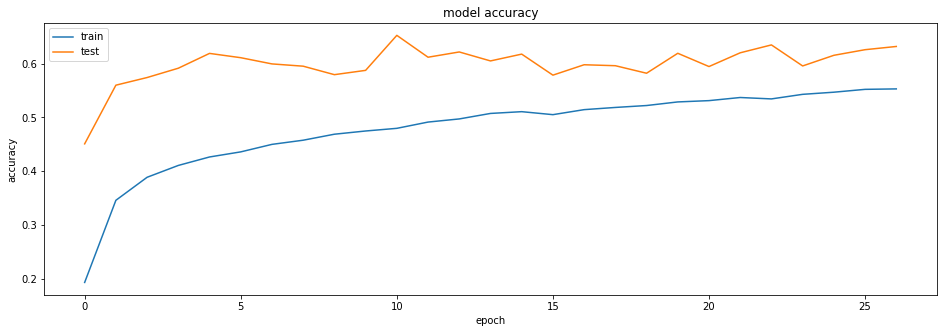

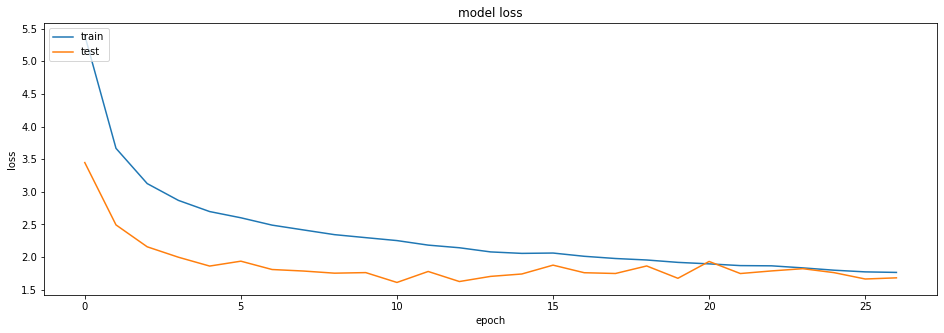

In [173]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(history_callback.history['accuracy'])
plt.plot(history_callback.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Using previous model output predictions as input
*Let's try to use chord embeddings to smooth predictions and apply harmonic tonality*
<br><br>
**Embeddings with BLSTM**
1. Data -> Embeddings -> e
2. Data -> BLSTM -> x
3. x, e -> BLSTM -> output1
4. output1 -> Dense -> predictions

In [142]:
# model with full concatenation
def Embeddings_BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    embeddings_input = Input(shape=(maxLen,), name='embeddings_input')
    
    #Embedding layer
    e = Embedding(input_dim=chords_num, 
                  output_dim=25, 
                  input_length=maxLen)(embeddings_input)
    #BLSTM
    e = Bidirectional(LSTM(units=64, 
                           batch_input_shape = (batch_size, timesteps, frequencies_num),
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           return_sequences=True))(e)
    e = Dropout(0.5)(e)
    
    x = Bidirectional(LSTM(units=64, 
                           batch_input_shape = (batch_size, timesteps, frequencies_num),
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           return_sequences=True))(main_input)
    x = Dropout(0.5)(x)
    
    #merge input with embeddings
    merged = concatenate([x, e], axis=-1)
    
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units=64,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           return_sequences=True))(merged)
    x = Dropout(0.5)(x)
    
    x = Dense(128)(x)
    x = Activation('sigmoid')(x)
    
    #Dense for classification
    x = Dense(chords_num)(x)
    main_output = Activation('softmax')(x)
    
    #model
    model = Model(inputs=[main_input, embeddings_input], outputs=[main_output])

    return model

#### Double Input Model Call

In [143]:
epochs = 10
batch_size = 32

model = Embeddings_BLSTM_2Layer(len(Chords), frequencies_num, chunk_size, batch_size)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# train
test_data = [x_test, predictions]
history_callback_embeddings = model.fit([x_train, embeddings_train], [y_train], epochs=epochs,
          validation_data=([x_test, embeddings_test], y_test), batch_size=batch_size, verbose=1)

model.summary()

Train on 1519 samples, validate on 9 samples
Epoch 1/10
1519/1519 [==============================] - 41s 27ms/sample - loss: 4.2775 - accuracy: 0.1263 - val_loss: 3.0956 - val_accuracy: 0.4036
Epoch 2/10
1519/1519 [==============================] - 36s 24ms/sample - loss: 3.5199 - accuracy: 0.2661 - val_loss: 2.8537 - val_accuracy: 0.3718
Epoch 3/10
1519/1519 [==============================] - 35s 23ms/sample - loss: 3.2726 - accuracy: 0.3412 - val_loss: 2.7525 - val_accuracy: 0.4231
Epoch 4/10
1519/1519 [==============================] - 35s 23ms/sample - loss: 3.0289 - accuracy: 0.3855 - val_loss: 2.6532 - val_accuracy: 0.4593
Epoch 5/10
1519/1519 [==============================] - 35s 23ms/sample - loss: 2.8533 - accuracy: 0.4056 - val_loss: 2.6867 - val_accuracy: 0.4667
Epoch 6/10
1519/1519 [==============================] - 35s 23ms/sample - loss: 2.7103 - accuracy: 0.4264 - val_loss: 2.6896 - val_accuracy: 0.4787
Epoch 7/10
1519/1519 [==============================] - 35s 23ms/sa

In [149]:
# evaluate on test set
loss, accuracy = model.evaluate([x_test, embeddings_test], y_test, verbose=0)
print("Final test loss: ", loss, " and accuracy :", 100*accuracy, "%")

Final test loss:  3.4152798652648926  and accuracy : 29.71111238002777 %


### Double input with embeddings

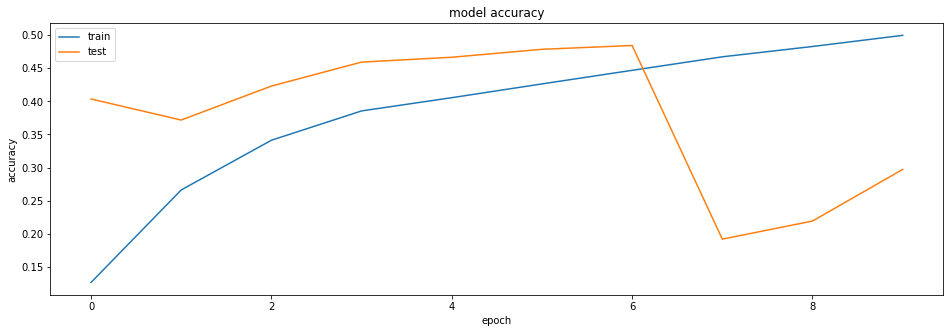

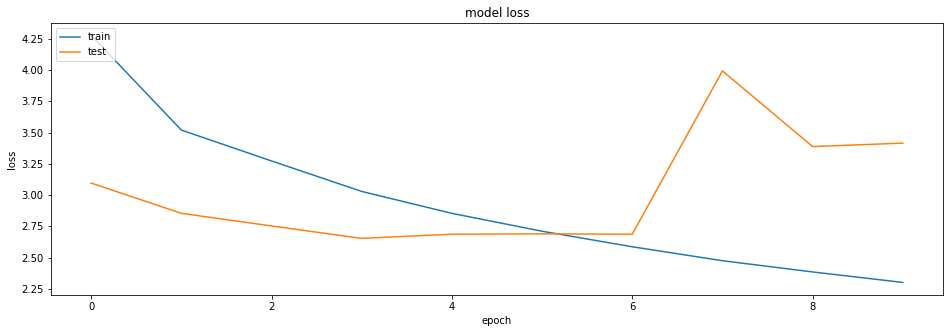

In [150]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(history_callback_embeddings.history['accuracy'])
plt.plot(history_callback_embeddings.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(history_callback_embeddings.history['loss'])
plt.plot(history_callback_embeddings.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Data Pre-Processing Part 2

### Appraoch 2 on annotation processing

- **Chord/Mode/Sus**<br><br>
Try an encoding(hashing) for each chord, and when we stumble upon each chord we hash it to a unique combination.<br>
<br>**Example**:<br>
<ol>
    <li> Find the chord between the 12 chords</li>
    <b>Chords:</b> C, C#, Db, D, D#, E, F, etc.<br>
    <li>Find the mode of the chord (major/minor)</li>
    <b>Mode:</b><br>
    Minor Chord: 0<br>
    Major Chord: 1<br>
    Diminished Chord: 2<br>
    Augmented Chord: 3<br>
    <li>Find any notes outside of the basic tonic triad</li>
    <b>Sustained: </b>
    0,4,6,7,9,11,13<br>
    </ol>
<br>
<br>
Triads: major, minor, diminished, augmented, suspended4<br>
 Quads: major-major 7, major-minor 7, major add9, major maj7/#5 <br>
        minor-major 7, minor-minor 7, minor add9, minor 7/b5<br>
        maj7/sus4, 7/sus4<br>

**For this implementation we will need:**<br>
Variables with: <br>
Dimension 1 = 3 [Chord, Mode, Sustained]<br>
Dimension 2 = [One hot encodings for 12 classes of chords, 4 classes for modes, auxiliary tones]<br><br>
***Example:***<br>
**Dmajor7** = [[000100000000],[0100],[0001000]]<br>
**C** = [[100000000000],[0100],[10000000]]<br>
*Data* = [[[000100000000],[0100],[0001000]], ... , [[100000000000],[0100],[1000000]]]<br>

So our model is going to have **3 outputs**, *one for each segment* and **1 input** for the spectrograms